# Download the dataset

In [1]:
!wget --no-check-certificate http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
!wget --no-check-certificate http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
!wget --no-check-certificate http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
!wget --no-check-certificate http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz

!gzip -f -d train-images-idx3-ubyte.gz
!gzip -f -d train-labels-idx1-ubyte.gz
!gzip -f -d t10k-images-idx3-ubyte.gz
!gzip -f -d t10k-labels-idx1-ubyte.gz

--2023-05-30 03:53:57--  http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 104.21.29.36, 172.67.171.76, 2606:4700:3036::ac43:ab4c, ...
Connecting to yann.lecun.com (yann.lecun.com)|104.21.29.36|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9912422 (9.5M) [application/x-gzip]
Saving to: ‘train-images-idx3-ubyte.gz’

train-images-idx3-u 100%[===================>]   9.45M  --.-KB/s    in 0.1s    

2023-05-30 03:53:57 (95.2 MB/s) - ‘train-images-idx3-ubyte.gz’ saved [9912422/9912422]

--2023-05-30 03:53:57--  http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 104.21.29.36, 172.67.171.76, 2606:4700:3036::ac43:ab4c, ...
Connecting to yann.lecun.com (yann.lecun.com)|104.21.29.36|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28881 (28K) [application/x-gzip]
Saving to: ‘train-labels-idx1-ubyte.gz’

train-labels-idx1-u 100%[===========

In [2]:
!pip install idx2numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for idx2numpy: filename=idx2numpy-1.2.3-py3-none-any.whl size=7903 sha256=d13b482fc55410e8c07e083d0197101fd75b162734213c946752b3c81b10f065
  Stored in directory: /root/.cache/pip/wheels/e0/f4/e7/643fc5f932ec2ff92997f43f007660feb23f948aa8486f1107
Successfully built idx2numpy


In [3]:
!pip install ipympl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 51.5 MB/s eta 0:00:00


# Imports

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import idx2numpy

import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F

from tqdm.notebook import tqdm

In [5]:
imgs   = idx2numpy.convert_from_file('train-images-idx3-ubyte')
labels = idx2numpy.convert_from_file('train-labels-idx1-ubyte')

# Helper functions

In [6]:
def sample(mean, log_var):
    std = torch.exp(0.5*log_var)
    eps = torch.randn_like(std, device=mean.device)
    return mean + eps*std

In [7]:
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    return total_params

In [8]:
def plot_losses(reco_losses, kld_losses):
    fig = plt.figure(figsize=(10, 5))

    ax = fig.add_subplot(1, 2, 1)
    ax.plot(reco_losses)
    ax.set_title('Reconstruction Loss')

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(kld_losses)
    ax.set_title('KLD Loss')

In [9]:
def generate_imgs(decoder_nn, cond=False):
    num_img = 32
    new_z = torch.randn(32, 2)
    if torch.cuda.is_available():
        new_z = new_z.cuda()

    if cond:
        new_labels = torch.zeros(num_img, 10).cuda()
        rand_int = torch.randint(0, 10, (num_img,)).cuda()
        new_labels[torch.arange(num_img), rand_int] = 1

        new_pred = decoder_nn(new_z, new_labels)
    else:
        new_pred = decoder_nn(new_z)

    new_pred = new_pred.cpu().detach().numpy()

    fig = plt.figure(figsize=(20, 10))
    gs = GridSpec(4, 8)

    for i in range(32):
        ax = fig.add_subplot(gs[i])
        img_array = new_pred[i][0]
        ax.imshow(img_array, cmap='gray')
        ax.axis('off')
        if cond:
            ax.set_title(f'Cond input: {rand_int[i]}')

In [10]:
def plot_z_dist(train_dl, encoder_nn, cond=False):
    fig = plt.figure(figsize=(24, 6))
    gs = GridSpec(1, 4)


    mus = []; log_vars = []; zs = []; ys = []
    for xb, yb, yb_one_hot in train_dl:
        if torch.cuda.is_available():
            xb = xb.cuda()
            yb_one_hot = yb_one_hot.cuda()

        if cond:
            mu, log_var = encoder_nn(xb, yb_one_hot)
        else:
            mu, log_var = encoder_nn(xb)
        z = sample(mu, log_var)

        mu = mu.cpu().detach().numpy()
        log_var = log_var.cpu().detach().numpy()
        z = z.cpu().detach().numpy()

        mus.extend(mu.tolist())
        log_vars.extend(log_var.tolist())
        zs.extend(z.tolist())
        ys.extend(yb.tolist())

    zs = np.array(zs)
    mus = np.array(mus)
    log_vars = np.array(log_vars)
    ys = np.array(ys)


    ax = fig.add_subplot(gs[0])
    ax.scatter(zs[:, 0], zs[:, 1], c=ys, cmap='tab10', alpha=0.3, s=1)
    ax.set_title('Z')
    ax.grid()
    ax.set_aspect('equal')

    gauss0 = np.random.normal(0, 1, len(zs[:, 0]))
    gauss1 = np.random.normal(0, 1, len(zs[:, 0]))
    ax = fig.add_subplot(gs[1])
    ax.scatter(gauss0, gauss1, c='cornflowerblue', alpha=0.3, s=1)
    ax.set_title('Gaus(0,1))')
    ax.set_aspect('equal')

    return ys, zs

# Dataset and Dataloader

In [11]:
class MyDataset(Dataset):
    def __init__(self, img_file, label_file):

        # load the images and the labels
        self.img_array   = idx2numpy.convert_from_file(img_file)
        self.label_array = idx2numpy.convert_from_file(label_file)

        # reshape image to NCHW
        self.img_array = self.img_array.reshape(-1, 1, 28, 28)

        # convert to tensor
        self.img_array   = torch.tensor(self.img_array).float()/255
        self.label_array = torch.tensor(self.label_array)

    def __len__(self):
        return len(self.label_array)

    def __getitem__(self, idx):
        img, label = self.img_array[idx], self.label_array[idx]
        one_hot_label = torch.zeros(10)
        one_hot_label[label.item()] = 1
        return img, label, one_hot_label

In [12]:
train_ds = MyDataset('train-images-idx3-ubyte', 'train-labels-idx1-ubyte')
val_ds   = MyDataset('t10k-images-idx3-ubyte', 't10k-labels-idx1-ubyte')

In [13]:
train_dl = DataLoader(train_ds, batch_size=500, shuffle=True, num_workers=2)
val_dl   = DataLoader(val_ds, batch_size=5000, shuffle=False, num_workers=2)

# AutoEncoder (AE)

### Networks

In [14]:
# Encoder
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.seq1 = nn.Sequential(
            nn.Linear(28*28, 300),
            nn.LeakyReLU(),

            nn.Linear(300, 200),
            nn.LeakyReLU(),

            nn.Linear(200, 100),
            nn.LeakyReLU()
        )

        self.mean_nn    = nn.Linear(100, 2)
        self.log_var_nn = nn.Linear(100, 2)


    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.seq1(x)

        mean = self.mean_nn(x)
        log_var = self.log_var_nn(x)

        return mean, log_var
    

# Decoder
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.seq1 = nn.Sequential(
            nn.Linear(2, 100),
            nn.LeakyReLU(),

            nn.Linear(100, 200),
            nn.LeakyReLU(),

            nn.Linear(200, 300),
            nn.LeakyReLU(),

            nn.Linear(300, 28*28),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.seq1(x)
        x = x.view(-1, 1, 28, 28)        

        return x

In [15]:
encoder_nn = Encoder()
decoder_nn = Decoder()

if torch.cuda.is_available():
    encoder_nn.cuda()
    decoder_nn.cuda()

In [16]:
print(f'Encoder has {count_parameters(encoder_nn):,} trainable parameters')
print(f'Decoder has {count_parameters(decoder_nn):,} trainable parameters')

Encoder has 316,204 trainable parameters
Decoder has 316,784 trainable parameters


In [17]:
optimizer = torch.optim.Adam(list(encoder_nn.parameters()) + list(decoder_nn.parameters()), lr=0.001)

In [18]:
reco_losses = []
kld_losses  = []

for ep in tqdm(range(50)):
    for xb, yb, _ in train_dl:
        if torch.cuda.is_available():
            xb = xb.cuda()
            yb = yb.cuda()


        optimizer.zero_grad()

        mu, log_var = encoder_nn(xb)
        z = sample(mu, log_var)

        pred = decoder_nn(z)

        # loss
        reco_loss = BCE = F.binary_cross_entropy(pred, xb, reduction='sum')
        kld_loss  = -0.5 * torch.sum(1 + log_var - mu**2 -  log_var.exp())

        loss = reco_loss + 0 * kld_loss

        loss.backward()
        optimizer.step()

        reco_losses.append(reco_loss.item())
        kld_losses.append(kld_loss.item())


  0%|          | 0/50 [00:00<?, ?it/s]

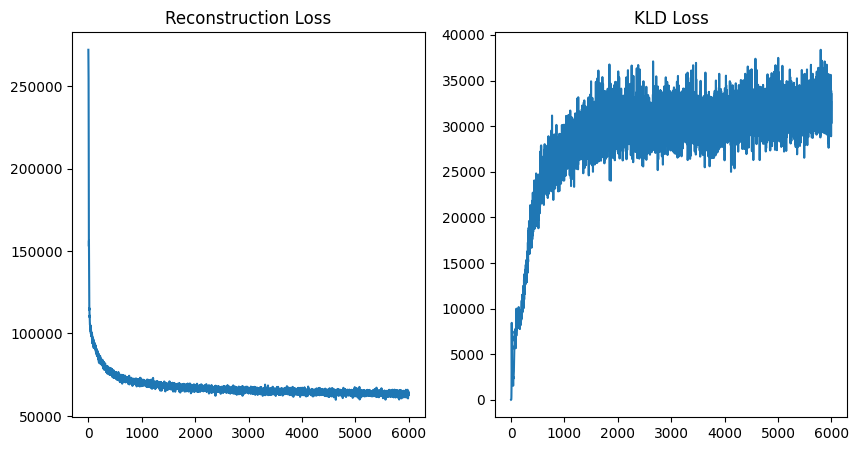

In [19]:
plot_losses(reco_losses, kld_losses)

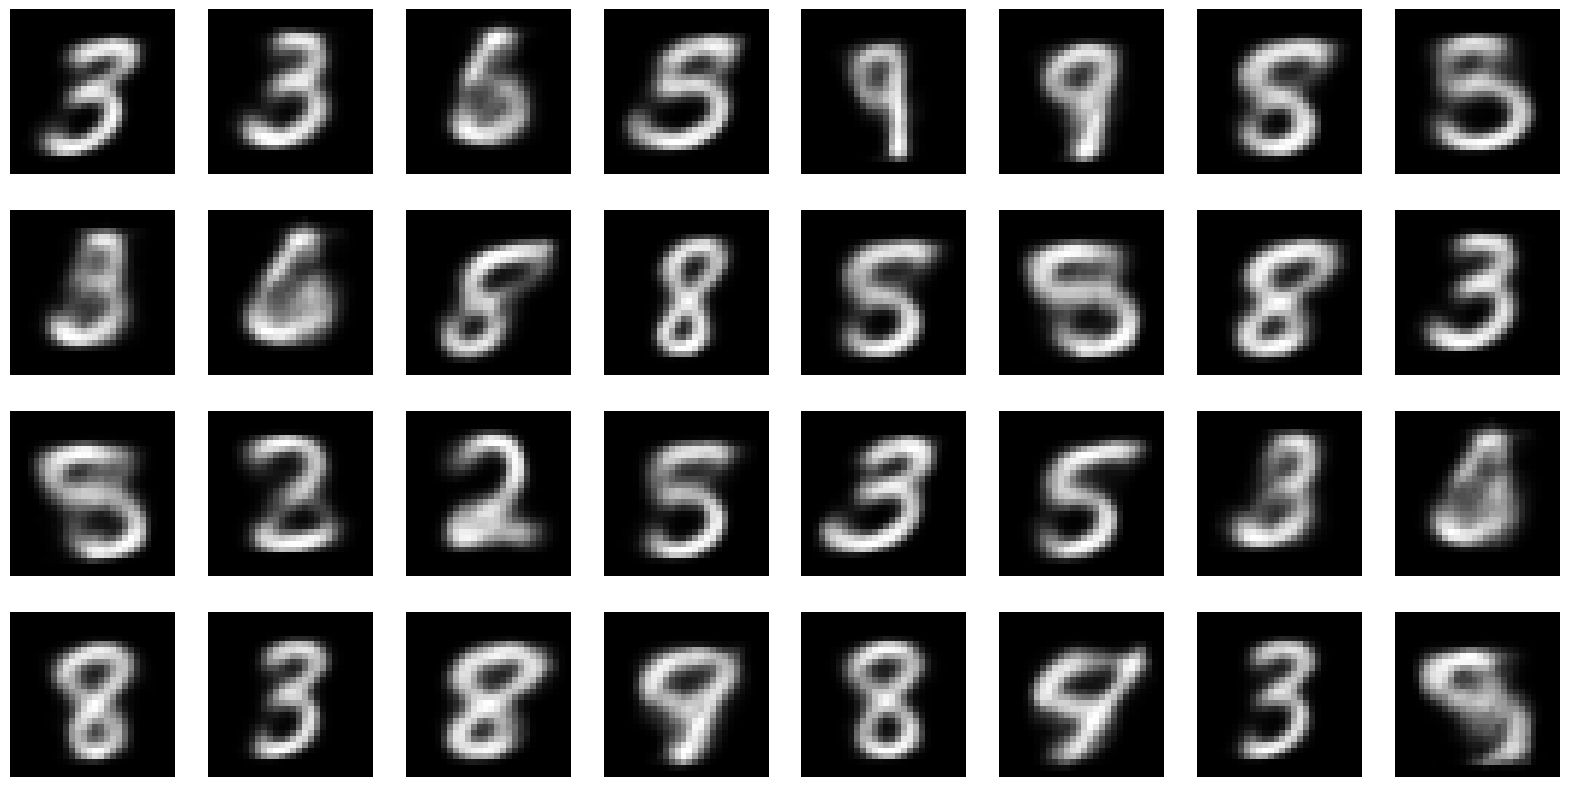

In [20]:
generate_imgs(decoder_nn)

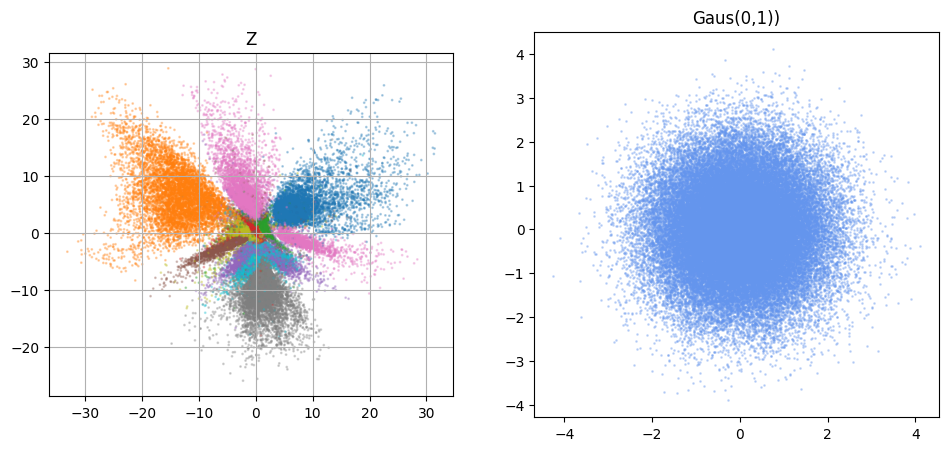

In [21]:
ys, zs = plot_z_dist(train_dl=train_dl, encoder_nn=encoder_nn)

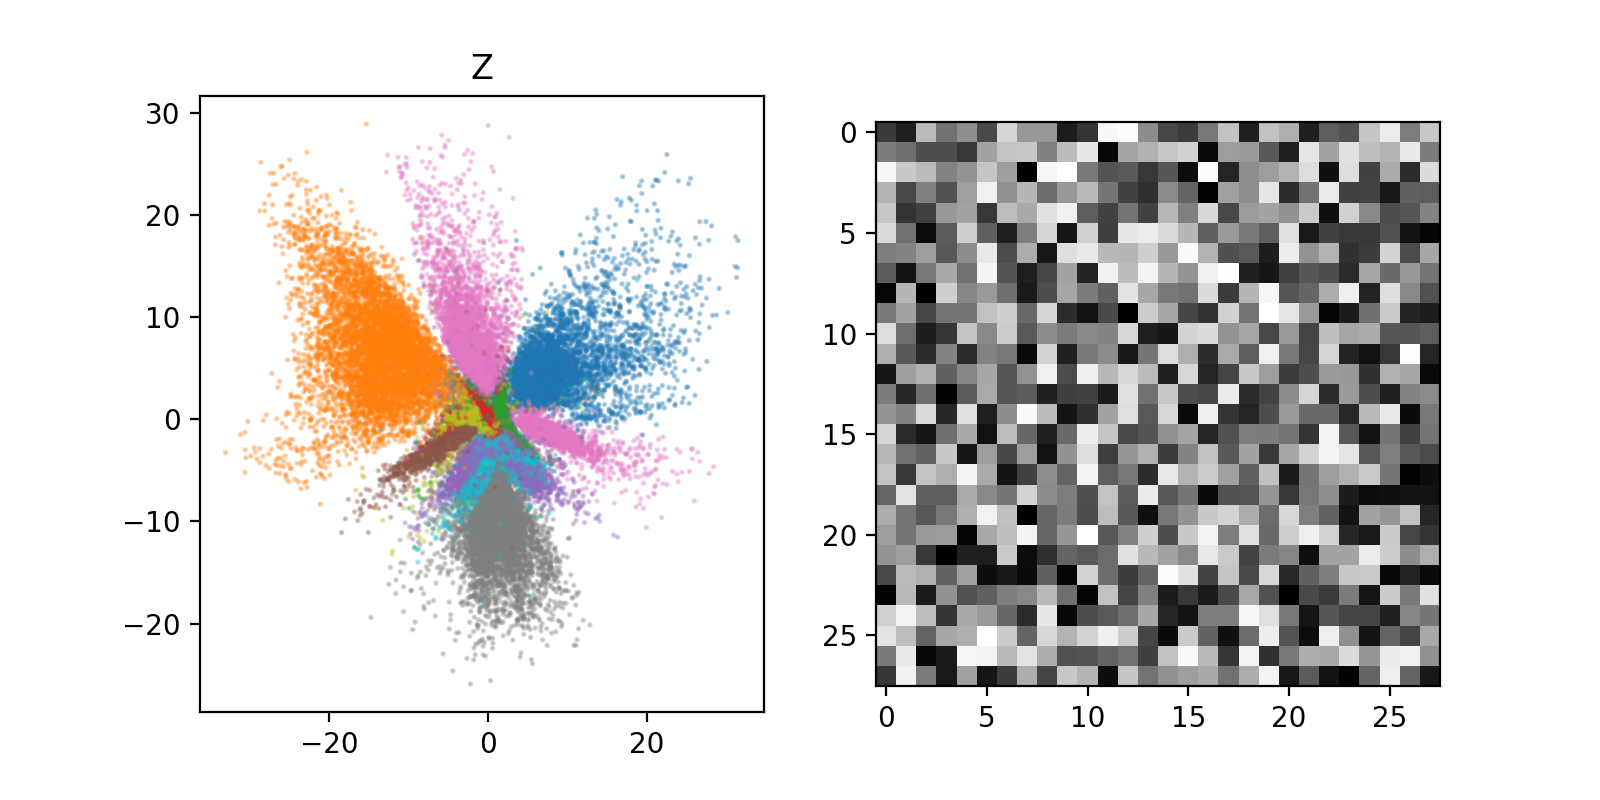

In [23]:
%matplotlib widget

from google.colab import output
output.enable_custom_widget_manager()

import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets

# Create the figure and subplots
fig = plt.figure(figsize=(8,4), dpi=200)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# Plot data in the first subplot
ax1.scatter(zs[:, 0], zs[:, 1], c=ys, cmap='tab10', alpha=0.3, s=1)
ax1.set_title('Z')

# Plot data in the second subplot
x2 = []
y2 = []
points = ax2.imshow(np.random.rand(28,28), cmap='gray')

# Define the click event handler function
def onclick(event):
    if event.inaxes == ax1:
        x, y = event.xdata, event.ydata
        new_z = torch.tensor([[x,y]], dtype=torch.float32)
        if torch.cuda.is_available():
            new_z = new_z.cuda()
        new_pred = decoder_nn(new_z)
        new_pred = new_pred.cpu().detach().numpy()[0][0]

        points.set_data(new_pred)
        ax2.relim()
        ax2.autoscale_view()
        ax2.set_title(f'x: {x:.1f}, y: {y:.1f}')
        ax2.axis('off')
        fig.canvas.draw()

# Connect the click event handler to the figure
fig.canvas.mpl_connect('button_press_event', onclick)

# Display the plot
plt.show()


# **Variational** Auto Encoder (VAE)

In [ ]:
encoder_nn = Encoder()
decoder_nn = Decoder()

if torch.cuda.is_available():
    encoder_nn.cuda()
    decoder_nn.cuda()

In [ ]:
optimizer = torch.optim.Adam(list(encoder_nn.parameters()) + list(decoder_nn.parameters()), lr=0.001)

In [ ]:
reco_losses = []
kld_losses  = []

for ep in tqdm(range(50)):
    for xb, yb, _ in train_dl:
        if torch.cuda.is_available():
            xb = xb.cuda()
            yb = yb.cuda()


        optimizer.zero_grad()

        mu, log_var = encoder_nn(xb)
        z = sample(mu, log_var)

        pred = decoder_nn(z)

        # loss
        reco_loss = BCE = F.binary_cross_entropy(pred, xb, reduction='sum')
        kld_loss  = -0.5 * torch.sum(1 + log_var - mu**2 -  log_var.exp())

        loss = reco_loss + kld_loss

        loss.backward()
        optimizer.step()

        reco_losses.append(reco_loss.item())
        kld_losses.append(kld_loss.item())


  0%|          | 0/50 [00:00<?, ?it/s]

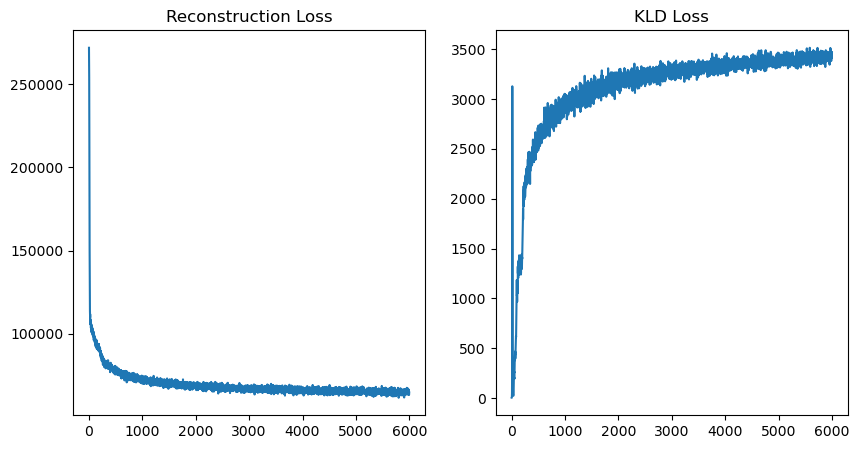

In [ ]:
plot_losses(reco_losses, kld_losses)

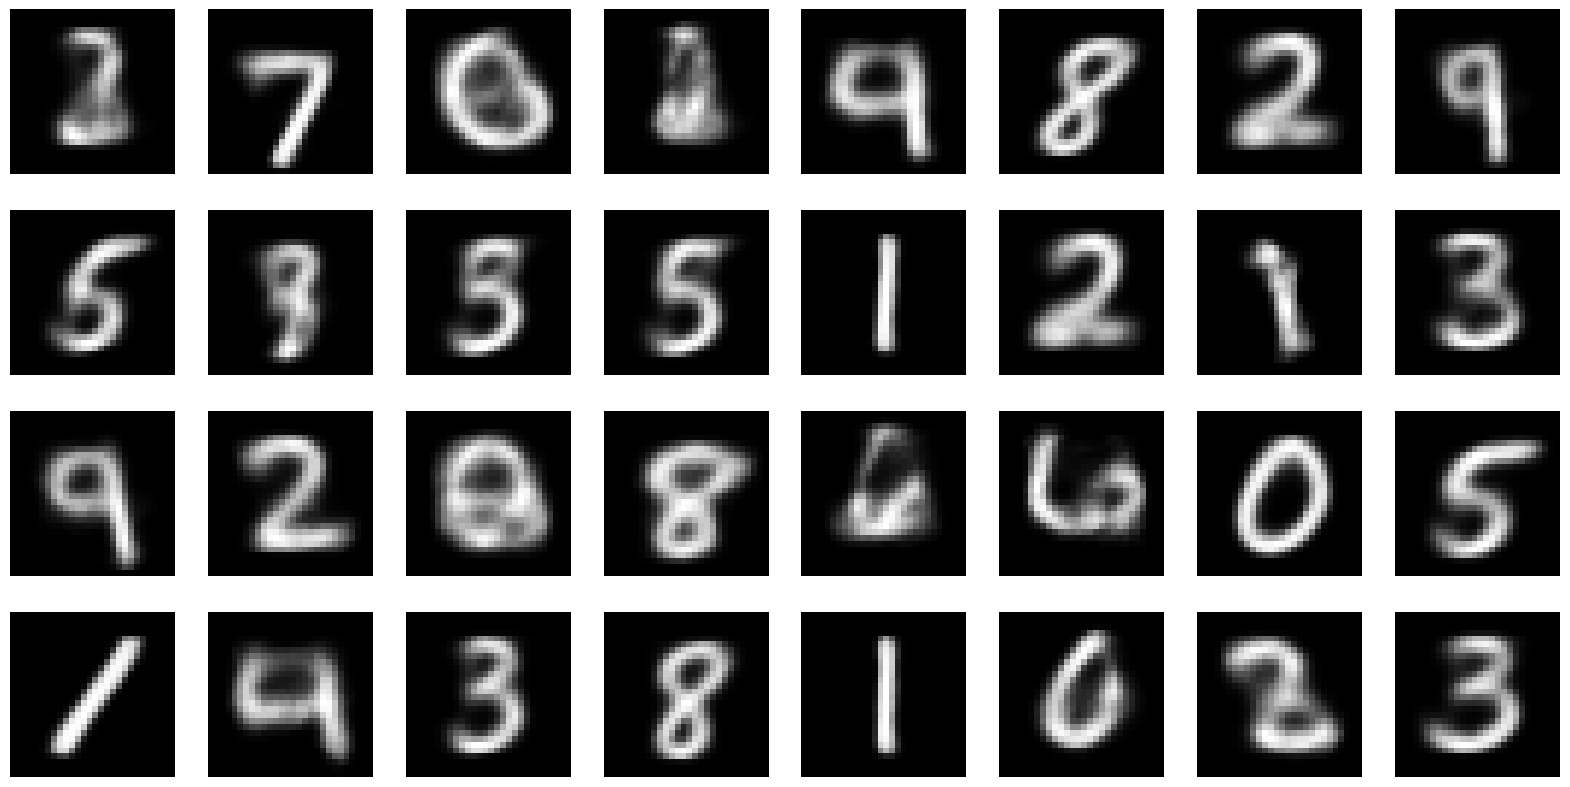

In [ ]:
generate_imgs(decoder_nn, cond=False)

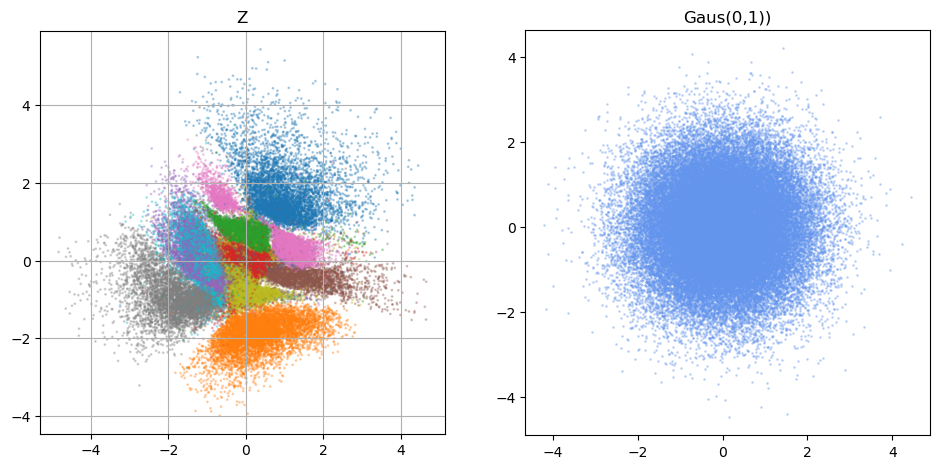

In [ ]:
plot_z_dist(train_dl=train_dl, encoder_nn=encoder_nn)

# **Conditional** Variational Auto Encoder (cVAE)

### Networks

In [ ]:
# Encoder
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.seq1 = nn.Sequential(
            nn.Linear(28*28 + 10, 300),
            nn.LeakyReLU(),

            nn.Linear(300, 200),
            nn.LeakyReLU(),

            nn.Linear(200, 100),
            nn.LeakyReLU()
        )

        self.mean_nn    = nn.Linear(100, 2)
        self.log_var_nn = nn.Linear(100, 2)


    def forward(self, x, one_hot_label):
        x = x.view(-1, 28*28)
        x = torch.cat([x, one_hot_label], dim=1)
        x = self.seq1(x)

        mean = self.mean_nn(x)
        log_var = self.log_var_nn(x)

        return mean, log_var
    

# Decoder
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.seq1 = nn.Sequential(
            nn.Linear(2 + 10, 100),
            nn.LeakyReLU(),

            nn.Linear(100, 200),
            nn.LeakyReLU(),

            nn.Linear(200, 300),
            nn.LeakyReLU(),

            nn.Linear(300, 28*28),
            nn.Sigmoid()
        )

    def forward(self, x, one_hot_label):
        x = torch.cat([x, one_hot_label], dim=1)
        x = self.seq1(x)
        x = x.view(-1, 1, 28, 28)        

        return x

In [ ]:
encoder_nn = Encoder()
decoder_nn = Decoder()

if torch.cuda.is_available():
    encoder_nn.cuda()
    decoder_nn.cuda()

In [ ]:
optimizer = torch.optim.Adam(list(encoder_nn.parameters()) + list(decoder_nn.parameters()), lr=0.001)

In [ ]:
reco_losses = []
kld_losses  = []

for ep in tqdm(range(50)):
    for xb, yb, yb_one_hot in train_dl:
        if torch.cuda.is_available():
            xb = xb.cuda()
            yb = yb.cuda()
            yb_one_hot = yb_one_hot.cuda()


        optimizer.zero_grad()

        mu, log_var = encoder_nn(xb, yb_one_hot)
        z = sample(mu, log_var)

        pred = decoder_nn(z, yb_one_hot)

        # loss
        reco_loss = BCE = F.binary_cross_entropy(pred, xb, reduction='sum')
        kld_loss  = -0.5 * torch.sum(1 + log_var - mu**2 -  log_var.exp())

        loss = reco_loss + kld_loss

        loss.backward()
        optimizer.step()

        reco_losses.append(reco_loss.item())
        kld_losses.append(kld_loss.item())


  0%|          | 0/50 [00:00<?, ?it/s]

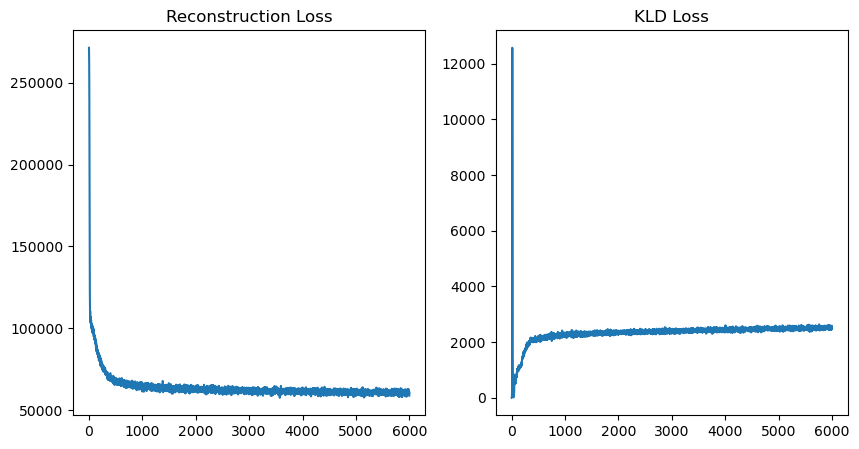

In [ ]:
plot_losses(reco_losses, kld_losses)

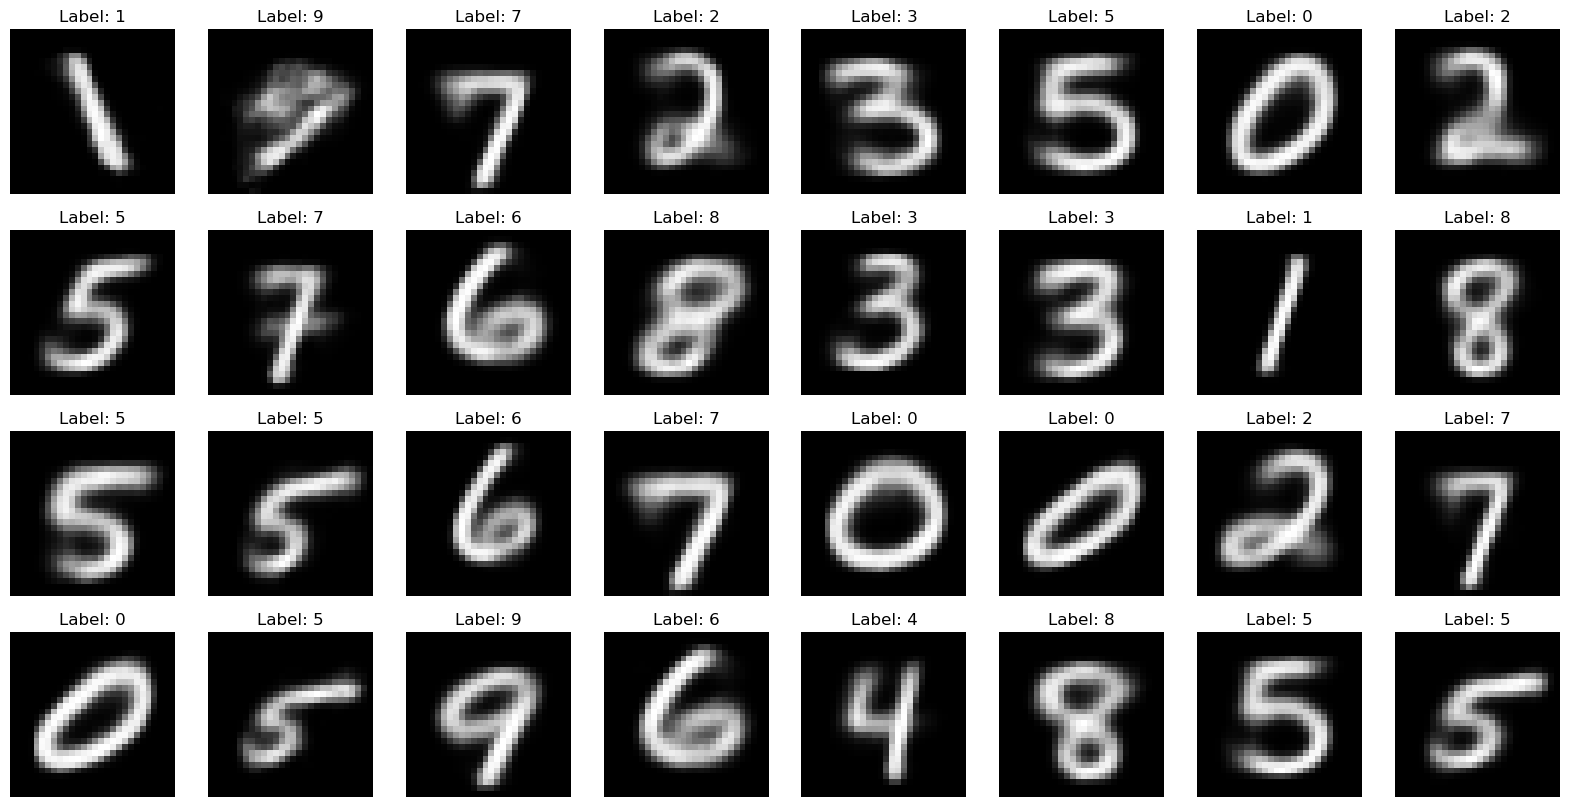

In [ ]:
generate_imgs(decoder_nn, cond=True)

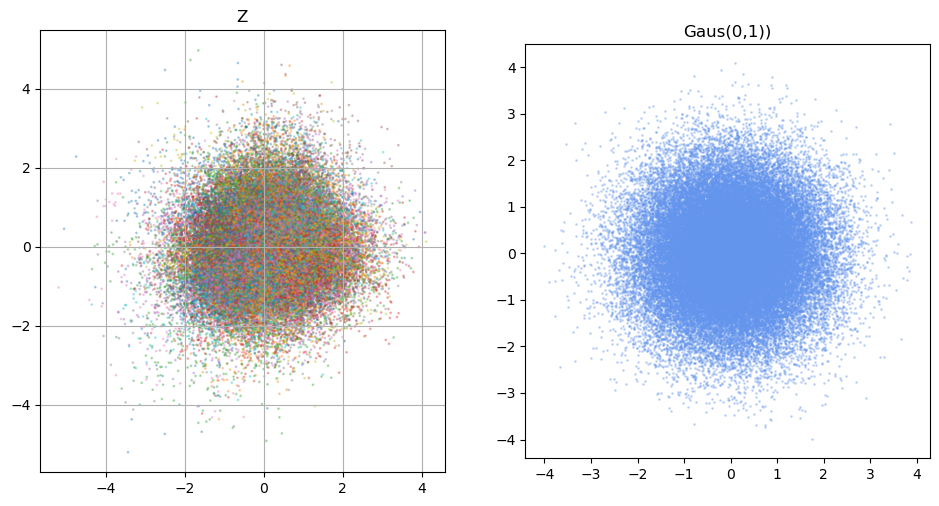

In [ ]:
plot_z_dist(train_dl=train_dl, encoder_nn=encoder_nn, cond=True)